# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Есть исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import xgboost as xgb
import time

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from IPython.core.interactiveshell import InteractiveShell
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import cross_validate as cval
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

import warnings
import logging

In [2]:
warnings.filterwarnings='ignore'
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = "all"
pd.options.mode.chained_assignment = None
state = np.random.RandomState(12345)
rs = 12345

In [3]:
def missing_value(df):
    missing_value = pd.DataFrame(columns=['NaN_part', 'empty_counts', 'space_counts', '0_counts', '-1_counts', 'unique_counts',\
                                          'dupl_sum', 'dtypes', 'length'], index=df.columns)
    for i in df.columns:
        missing_value['NaN_part'][i] = df[i].isnull().mean()
        missing_value['empty_counts'][i] = df[df[i] == ''][i].count()
        missing_value['space_counts'][i] = df[df[i] == ' '][i].count()
        missing_value['0_counts'][i] = df[(df[i] == 0)][i].count()
        missing_value['-1_counts'][i] = df[df[i] == -1][i].count()
        missing_value['unique_counts'][i] = len(df[i].unique())
        missing_value['dupl_sum'][i] = df[i].duplicated().sum()
        missing_value['dtypes'][i] = df[i].dtypes
        missing_value['length'][i] = len(df[i])
    return missing_value

In [4]:
def missing_val(df):
    missing_value = pd.DataFrame(columns=['NaN_part', 'empty_counts', 'space_counts', '0_counts', '-1_counts', 'unique_counts',\
                                          'min', 'max', 'dupl_sum', 'dtypes', 'length'], index=df.columns)
    for i in df.columns:
        missing_value['NaN_part'][i] = df[i].isnull().mean()
        missing_value['empty_counts'][i] = df[df[i] == ''][i].count()
        missing_value['space_counts'][i] = df[df[i] == ' '][i].count()
        missing_value['0_counts'][i] = df[(df[i] == 0)][i].count()
        missing_value['-1_counts'][i] = df[df[i] == -1][i].count()
        missing_value['unique_counts'][i] = len(df[i].unique())
        missing_value['min'][i] = df[i].min()
        missing_value['max'][i] = df[i].max()
        missing_value['dupl_sum'][i] = df[i].duplicated().sum()
        missing_value['dtypes'][i] = df[i].dtypes
        missing_value['length'][i] = len(df[i])
    return missing_value

In [5]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('datasets/autos.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df

DateCrawled  Price  VehicleType  RegistrationYear Gearbox  \
0       2016-03-24 11:52:17    480          NaN              1993  manual   
1       2016-03-24 10:58:45  18300        coupe              2011  manual   
2       2016-03-14 12:52:21   9800          suv              2004    auto   
3       2016-03-17 16:54:04   1500        small              2001  manual   
4       2016-03-31 17:25:20   3600        small              2008  manual   
...                     ...    ...          ...               ...     ...   
354364  2016-03-21 09:50:58      0          NaN              2005  manual   
354365  2016-03-14 17:48:27   2200          NaN              2005     NaN   
354366  2016-03-05 19:56:21   1199  convertible              2000    auto   
354367  2016-03-19 18:57:12   9200          bus              1996  manual   
354368  2016-03-20 19:41:08   3400        wagon              2002  manual   

        Power        Model  Kilometer  RegistrationMonth  FuelType  \
0           0         golf     150000                  0    petrol   
1         190          NaN     125000                  5  gasoline   
2         163        grand     125000                  8  gasoline   
3          75         golf     150000                  6    petrol   
4          69        fabia      90000                  7  gasoline   
...       ...          ...        ...                ...       ...   
354364      0         colt     150000                  7    petrol   
354365      0          NaN      20000                  1       NaN   
354366    101       fortwo     125000                  3    petrol   
354367    102  transporter     150000                  3  gasoline   
354368    100         golf     150000                  6  gasoline   

                 Brand NotRepaired          DateCreated  NumberOfPictures  \
0           volkswagen         NaN  2016-03-24 00:00:00                 0   
1                 audi         yes  2016-03-24 00:00:00                 0   
2                 jeep         NaN  2016-03-14 00:00:00                 0   
3           volkswagen          no  2016-03-17 00:00:00                 0   
4                skoda          no  2016-03-31 00:00:00                 0   
...                ...         ...                  ...               ...   
354364      mitsubishi         yes  2016-03-21 00:00:00                 0   
354365  sonstige_autos         NaN  2016-03-14 00:00:00                 0   
354366           smart          no  2016-03-05 00:00:00                 0   
354367      volkswagen          no  2016-03-19 00:00:00                 0   
354368      volkswagen         NaN  2016-03-20 00:00:00                 0   

        PostalCode             LastSeen  
0            70435  2016-04-07 03:16:57  
1            66954  2016-04-07 01:46:50  
2            90480  2016-04-05 12:47:46  
3            91074  2016-03-17 17:40:17  
4            60437  2016-04-06 10:17:21  
...            ...                  ...  
354364        2694  2016-03-21 10:42:49  
354365       39576  2016-04-06 00:46:52  
354366       26135  2016-03-11 18:17:12  
354367       87439  2016-04-07 07:15:26  
354368       40764  2016-03-24 12:45:21  

[354369 rows x 16 columns]

In [8]:
df.describe()

Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

In [9]:
df = df[['DateCreated', 'DateCrawled', 'Brand', 'Model', 'RegistrationYear', 'RegistrationMonth', 'VehicleType', 'Gearbox', \
        'Power', 'Kilometer', 'FuelType', 'NotRepaired', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'Price']]

In [10]:
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCreated', 'DateCrawled', 'LastSeen', 'RegistrationMonth'], axis=1)

### Проверю количественные признаки

Text(0.5, 0.98, 'Распределение количественных данных')

Text(0.5, 1.0, 'Price')

Text(0.5, 1.0, 'Power')

Text(0.5, 1.0, 'RegistrationYear')

Text(0.5, 1.0, 'Kilometer')

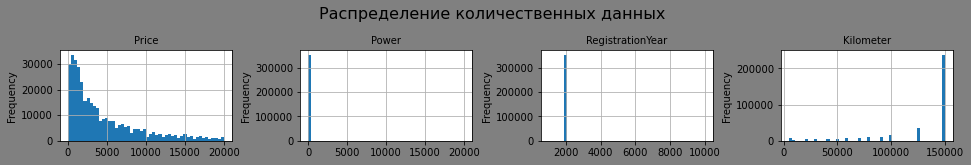

In [11]:
graphic = df[['Price', 'Power', 'RegistrationYear', 'Kilometer']]
fig = plt.figure(figsize=(16, 6), facecolor='gray')
fig.suptitle(f'Распределение количественных данных', fontsize=16);
plt.subplots_adjust(wspace=0.4, hspace=0.3)
subplots = 1

for feature in graphic.columns:
    ax = fig.add_subplot(3,4,subplots)
    ax = df[feature].plot(kind='hist', bins=50, grid=True)
    ax.set_title(graphic[feature].name, fontsize=10)
    subplots += 1
plt.show();

In [12]:
print(sorted(df.RegistrationYear.unique()))

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]


Год изменяется от 1000 до 9999 от Рождества Христова.

In [13]:
display(df.query('RegistrationYear < 1900 | RegistrationYear > 2019'))

Brand   Model  RegistrationYear VehicleType Gearbox  Power  \
622               opel     NaN              1111         NaN     NaN      0   
12946       volkswagen    golf              5000         NaN     NaN      0   
15147   sonstige_autos     NaN              9999         NaN     NaN      0   
15870   sonstige_autos     NaN              3200         NaN     NaN      0   
16062             ford  mondeo              1000         NaN     NaN      0   
...                ...     ...               ...         ...     ...    ...   
340548  sonstige_autos     NaN              3500         NaN  manual     75   
340759            audi      a3              1600         NaN  manual   1600   
341791            opel  zafira              3000         NaN     NaN      0   
348830  sonstige_autos     NaN              1000         NaN     NaN   1000   
351682            fiat   other              1800         NaN     NaN     16   

        Kilometer FuelType NotRepaired  Price  
622          5000      NaN         NaN      0  
12946        5000      NaN         NaN     49  
15147       10000      NaN         NaN      0  
15870        5000      NaN         NaN   1700  
16062        5000      NaN         NaN    190  
...           ...      ...         ...    ...  
340548       5000   petrol         NaN      0  
340759     150000   petrol          no    700  
341791       5000      NaN         NaN      1  
348830     150000      NaN         NaN      1  
351682       5000   petrol         NaN  11500  

[171 rows x 10 columns]

In [14]:
print(sorted(df.Power.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Мощность изменяется от нуля до 20 000 л.с. Самое мощное авто на данный момент Devel Sixteen - 5000 л.с. В целом мощность авто не превышает 2000 л.с. Левый порог сложно ограничить, возможно продают артефакты, которые не ездят. Самое маломощное авто Peel P50 - 4.2 л.с., запорожец - до 30 л.с.

In [15]:
df.query('Power == 0')

Brand     Model  RegistrationYear VehicleType Gearbox  Power  \
0           volkswagen      golf              1993         NaN  manual      0   
15                ford        ka              1910       small     NaN      0   
32          volkswagen      golf              1994       sedan     NaN      0   
37             renault    kangoo              2016         NaN     NaN      0   
40                opel     corsa              1990         NaN     NaN      0   
...                ...       ...               ...         ...     ...    ...   
354338            opel       NaN              1995         NaN     NaN      0   
354346   mercedes_benz  c_klasse              2005         NaN    auto      0   
354363            opel    zafira              2000         bus  manual      0   
354364      mitsubishi      colt              2005         NaN  manual      0   
354365  sonstige_autos       NaN              2005         NaN     NaN      0   

        Kilometer  FuelType NotRepaired  Price  
0          150000    petrol         NaN    480  
15           5000    petrol         NaN    450  
32         150000    petrol          no    245  
37         150000  gasoline          no   1500  
40         150000    petrol         NaN      0  
...           ...       ...         ...    ...  
354338     125000    petrol         NaN    180  
354346     150000       NaN         NaN   2600  
354363     150000    petrol          no   1150  
354364     150000    petrol         yes      0  
354365      20000       NaN         NaN   2200  

[40225 rows x 10 columns]

In [16]:
print(sorted(df.Kilometer.unique()))

[5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 125000, 150000]


Пробег скорее всего категоризировали, уж больно ровные числа выходят

In [17]:
for feature in graphic.columns:
    shapiro_test = st.shapiro(df[feature].dropna())
    print(shapiro_test)

ShapiroResult(statistic=0.8284087181091309, pvalue=0.0)
ShapiroResult(statistic=0.15523284673690796, pvalue=0.0)
ShapiroResult(statistic=0.01994854211807251, pvalue=0.0)
ShapiroResult(statistic=0.6375402212142944, pvalue=0.0)


C:\Users\George\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Ни один из признаков не имеет значимого нормального распределения

In [18]:
corr_stacked = df.corr().unstack().sort_values(ascending=False).reset_index()
corr_stacked.columns=['features_1', 'features_2', 'corr']

collinear_features = corr_stacked.query('corr > 0.7')
collinear_features

features_1        features_2  corr
0             Price             Price   1.0
1         Kilometer         Kilometer   1.0
2             Power             Power   1.0
3  RegistrationYear  RegistrationYear   1.0

<AxesSubplot:>

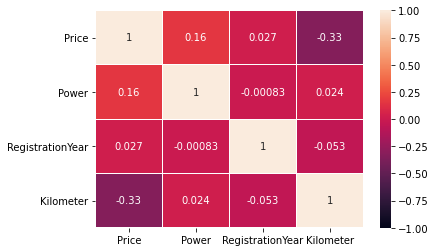

In [19]:
sns.heatmap(graphic.corr(), vmin=-1, vmax=1, annot=True, linewidth=0.01)

Мультиколлинеарность отсутствует

### Проверю качественные признаки

In [20]:
print(sorted(df.Brand.unique()))

['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']


In [21]:
print(df.Model.unique())

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

In [22]:
print(df.VehicleType.unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


In [23]:
print(df.Gearbox.unique())

['manual' 'auto' nan]


In [24]:
print(df.FuelType.unique())

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


In [25]:
print(df.NotRepaired.unique())

[nan 'yes' 'no']


### Вывод

In [26]:
miss = missing_value(df)
miss

NaN_part empty_counts space_counts 0_counts -1_counts  \
Brand                     0            0            0        0         0   
Model             0.0556059            0            0        0         0   
RegistrationYear          0            0            0        0         0   
VehicleType        0.105794            0            0        0         0   
Gearbox           0.0559671            0            0        0         0   
Power                     0            0            0    40225         0   
Kilometer                 0            0            0        0         0   
FuelType           0.092827            0            0        0         0   
NotRepaired        0.200791            0            0        0         0   
Price                     0            0            0    10772         0   

                 unique_counts dupl_sum  dtypes  length  
Brand                       40   354329  object  354369  
Model                      251   354118  object  354369  
RegistrationYear           151   354218   int64  354369  
VehicleType                  9   354360  object  354369  
Gearbox                      3   354366  object  354369  
Power                      712   353657   int64  354369  
Kilometer                   13   354356   int64  354369  
FuelType                     8   354361  object  354369  
NotRepaired                  3   354366  object  354369  
Price                     3731   350638   int64  354369

Необходимо:
- заменить 0 в данных на другие данные из датасета
- заменить пропуски на 'other'
- удалить NumberOfPictures, PostalCode, RegistrationMonth, DateCreated, DateCrawled, LastSeen
- обработать RegistrationYear, год имеет диапазон [1000, 9999]. 
- обработать Power, мощность от 0 до 20000 л.с., чего не существует в природе

### Обработаю количественные признаки

Обработаю признак Power

In [27]:
df.query('Power > 2000')

Brand    Model  RegistrationYear VehicleType Gearbox  Power  \
7661    volkswagen     lupo              1999       small  manual   7515   
11039         fiat    other              1998       sedan  manual  10317   
19092          bmw      5er              2005       wagon    auto   2729   
25232   volkswagen    caddy              2009         bus  manual  10520   
33952       toyota     aygo              2006       small  manual   6920   
...            ...      ...               ...         ...     ...    ...   
346639  mitsubishi  carisma              2000       sedan  manual  12512   
346690         bmw      5er              2017         NaN    auto   2018   
348137  volkswagen     golf              1993       sedan    auto   9012   
348237        opel    corsa              2007       coupe  manual   2007   
348668        audi       a6              1996       wagon  manual   2598   

        Kilometer  FuelType NotRepaired  Price  
7661       150000    petrol         NaN   1499  
11039      150000    petrol          no      0  
19092      150000  gasoline          no   9750  
25232      150000  gasoline          no  10900  
33952       90000       NaN          no   3740  
...           ...       ...         ...    ...  
346639     150000    petrol         NaN   1300  
346690     150000       NaN          no   7498  
348137     150000    petrol         NaN    850  
348237     150000  gasoline         yes   3000  
348668     150000       NaN         NaN   1000  

[120 rows x 10 columns]

Power можно воспроизвести по бренду и модели авто.

In [28]:
df1 = df.groupby(['Brand', 'Model'])['Power'].median().reset_index()
df1[df1.Model == 'golf']

Brand Model  Power
273  volkswagen  golf   95.0

In [29]:
df

Brand        Model  RegistrationYear  VehicleType Gearbox  \
0           volkswagen         golf              1993          NaN  manual   
1                 audi          NaN              2011        coupe  manual   
2                 jeep        grand              2004          suv    auto   
3           volkswagen         golf              2001        small  manual   
4                skoda        fabia              2008        small  manual   
...                ...          ...               ...          ...     ...   
354364      mitsubishi         colt              2005          NaN  manual   
354365  sonstige_autos          NaN              2005          NaN     NaN   
354366           smart       fortwo              2000  convertible    auto   
354367      volkswagen  transporter              1996          bus  manual   
354368      volkswagen         golf              2002        wagon  manual   

        Power  Kilometer  FuelType NotRepaired  Price  
0           0     150000    petrol         NaN    480  
1         190     125000  gasoline         yes  18300  
2         163     125000  gasoline         NaN   9800  
3          75     150000    petrol          no   1500  
4          69      90000  gasoline          no   3600  
...       ...        ...       ...         ...    ...  
354364      0     150000    petrol         yes      0  
354365      0      20000       NaN         NaN   2200  
354366    101     125000    petrol          no   1199  
354367    102     150000  gasoline          no   9200  
354368    100     150000  gasoline         NaN   3400  

[354369 rows x 10 columns]

In [30]:
df.loc[df['Power'] < 30, 'Power'] = np.NaN
df.loc[df['Power'] > 2000, 'Power'] = np.NaN
df['Power'] = pd.Series(df.groupby(['Brand', 'Model'])['Power'].apply(lambda x: x.fillna(x.median())))
df

Brand        Model  RegistrationYear  VehicleType Gearbox  \
0           volkswagen         golf              1993          NaN  manual   
1                 audi          NaN              2011        coupe  manual   
2                 jeep        grand              2004          suv    auto   
3           volkswagen         golf              2001        small  manual   
4                skoda        fabia              2008        small  manual   
...                ...          ...               ...          ...     ...   
354364      mitsubishi         colt              2005          NaN  manual   
354365  sonstige_autos          NaN              2005          NaN     NaN   
354366           smart       fortwo              2000  convertible    auto   
354367      volkswagen  transporter              1996          bus  manual   
354368      volkswagen         golf              2002        wagon  manual   

        Power  Kilometer  FuelType NotRepaired  Price  
0       101.0     150000    petrol         NaN    480  
1         NaN     125000  gasoline         yes  18300  
2       163.0     125000  gasoline         NaN   9800  
3        75.0     150000    petrol          no   1500  
4        69.0      90000  gasoline          no   3600  
...       ...        ...       ...         ...    ...  
354364   82.0     150000    petrol         yes      0  
354365    NaN      20000       NaN         NaN   2200  
354366  101.0     125000    petrol          no   1199  
354367  102.0     150000  gasoline          no   9200  
354368  100.0     150000  gasoline         NaN   3400  

[354369 rows x 10 columns]

In [31]:
display(df[df.Power.isnull()])

Brand Model  RegistrationYear VehicleType Gearbox  Power  \
1                 audi   NaN              2011       coupe  manual    NaN   
59      sonstige_autos   NaN              1994         suv  manual    NaN   
81                fiat   NaN              1997       small  manual    NaN   
115         volkswagen   NaN              1999       small     NaN    NaN   
135               audi   NaN              1992       sedan  manual    NaN   
...                ...   ...               ...         ...     ...    ...   
354245            fiat   NaN              2001       small    auto    NaN   
354321  sonstige_autos   NaN              2007       wagon  manual    NaN   
354338            opel   NaN              1995         NaN     NaN    NaN   
354351      volkswagen   NaN              2000         NaN  manual    NaN   
354365  sonstige_autos   NaN              2005         NaN     NaN    NaN   

        Kilometer  FuelType NotRepaired  Price  
1          125000  gasoline         yes  18300  
59         150000       NaN         NaN      1  
81         150000       NaN         yes    350  
115          5000    petrol         NaN      0  
135        150000       NaN          no   1450  
...           ...       ...         ...    ...  
354245      90000    petrol         yes    560  
354321     150000  gasoline         yes   9400  
354338     125000    petrol         NaN    180  
354351     150000       NaN          no   1900  
354365      20000       NaN         NaN   2200  

[19707 rows x 10 columns]

In [32]:
df = df.dropna(subset=['Power']).reset_index(drop=True)

In [33]:
# display(df[(df['Brand'] == 'volkswagen') & (df['Model'] == 'golf')])

Обработаю признак RegistrationYear

In [34]:
df.loc[df['RegistrationYear'] < 1920, 'RegistrationYear'] = np.NaN
df.loc[df['RegistrationYear'] > 2019, 'RegistrationYear'] = np.NaN

In [35]:
df['RegistrationYear'] = pd.Series(df.groupby(['Brand', 'Model'])['RegistrationYear'].apply(lambda x: x.fillna(x.median())))
df

Brand        Model  RegistrationYear  VehicleType Gearbox  Power  \
0       volkswagen         golf            1993.0          NaN  manual  101.0   
1             jeep        grand            2004.0          suv    auto  163.0   
2       volkswagen         golf            2001.0        small  manual   75.0   
3            skoda        fabia            2008.0        small  manual   69.0   
4              bmw          3er            1995.0        sedan  manual  102.0   
...            ...          ...               ...          ...     ...    ...   
334657        opel       zafira            2000.0          bus  manual  125.0   
334658  mitsubishi         colt            2005.0          NaN  manual   82.0   
334659       smart       fortwo            2000.0  convertible    auto  101.0   
334660  volkswagen  transporter            1996.0          bus  manual  102.0   
334661  volkswagen         golf            2002.0        wagon  manual  100.0   

        Kilometer  FuelType NotRepaired  Price  
0          150000    petrol         NaN    480  
1          125000  gasoline         NaN   9800  
2          150000    petrol          no   1500  
3           90000  gasoline          no   3600  
4          150000    petrol         yes    650  
...           ...       ...         ...    ...  
334657     150000    petrol          no   1150  
334658     150000    petrol         yes      0  
334659     125000    petrol          no   1199  
334660     150000  gasoline          no   9200  
334661     150000  gasoline         NaN   3400  

[334662 rows x 10 columns]

In [36]:
display(df[df.RegistrationYear.isnull() == True])

Empty DataFrame
Columns: [Brand, Model, RegistrationYear, VehicleType, Gearbox, Power, Kilometer, FuelType, NotRepaired, Price]
Index: []

In [37]:
df = df.loc[df.Price > 400].reset_index(drop=True)

### Обработка качественных данных

Как воспроизвести пропуски в признаках VehicleType, Gearbox, FuelType я не знаю. Это качественные признаки. Заменю на 'other'

In [38]:
df = df.fillna('other')
df

Brand        Model  RegistrationYear  VehicleType Gearbox  Power  \
0       volkswagen         golf            1993.0        other  manual  101.0   
1             jeep        grand            2004.0          suv    auto  163.0   
2       volkswagen         golf            2001.0        small  manual   75.0   
3            skoda        fabia            2008.0        small  manual   69.0   
4              bmw          3er            1995.0        sedan  manual  102.0   
...            ...          ...               ...          ...     ...    ...   
306894        seat         leon            2004.0        sedan  manual  225.0   
306895        opel       zafira            2000.0          bus  manual  125.0   
306896       smart       fortwo            2000.0  convertible    auto  101.0   
306897  volkswagen  transporter            1996.0          bus  manual  102.0   
306898  volkswagen         golf            2002.0        wagon  manual  100.0   

        Kilometer  FuelType NotRepaired  Price  
0          150000    petrol       other    480  
1          125000  gasoline       other   9800  
2          150000    petrol          no   1500  
3           90000  gasoline          no   3600  
4          150000    petrol         yes    650  
...           ...       ...         ...    ...  
306894     150000    petrol         yes   3200  
306895     150000    petrol          no   1150  
306896     125000    petrol          no   1199  
306897     150000  gasoline          no   9200  
306898     150000  gasoline       other   3400  

[306899 rows x 10 columns]

In [39]:
value = missing_value(df)
value

NaN_part empty_counts space_counts 0_counts -1_counts  \
Brand                   0            0            0        0         0   
Model                   0            0            0        0         0   
RegistrationYear        0            0            0        0         0   
VehicleType             0            0            0        0         0   
Gearbox                 0            0            0        0         0   
Power                   0            0            0        0         0   
Kilometer               0            0            0        0         0   
FuelType                0            0            0        0         0   
NotRepaired             0            0            0        0         0   
Price                   0            0            0        0         0   

                 unique_counts dupl_sum   dtypes  length  
Brand                       39   306860   object  306899  
Model                      249   306650   object  306899  
RegistrationYear            89   306810  float64  306899  
VehicleType                  8   306891   object  306899  
Gearbox                      3   306896   object  306899  
Power                      538   306361  float64  306899  
Kilometer                   13   306886    int64  306899  
FuelType                     7   306892   object  306899  
NotRepaired                  3   306896   object  306899  
Price                     3452   303447    int64  306899

## Моделирование

### Подготовка модели

In [40]:
features = df.drop('Price', axis=1)
target = df['Price']

In [41]:
features_ohe = pd.get_dummies(features, drop_first=True)
features_ohe

RegistrationYear  Power  Kilometer  Brand_audi  Brand_bmw  \
0                 1993.0  101.0     150000           0          0   
1                 2004.0  163.0     125000           0          0   
2                 2001.0   75.0     150000           0          0   
3                 2008.0   69.0      90000           0          0   
4                 1995.0  102.0     150000           0          1   
...                  ...    ...        ...         ...        ...   
306894            2004.0  225.0     150000           0          0   
306895            2000.0  125.0     150000           0          0   
306896            2000.0  101.0     125000           0          0   
306897            1996.0  102.0     150000           0          0   
306898            2002.0  100.0     150000           0          0   

        Brand_chevrolet  Brand_chrysler  Brand_citroen  Brand_dacia  \
0                     0               0              0            0   
1                     0               0              0            0   
2                     0               0              0            0   
3                     0               0              0            0   
4                     0               0              0            0   
...                 ...             ...            ...          ...   
306894                0               0              0            0   
306895                0               0              0            0   
306896                0               0              0            0   
306897                0               0              0            0   
306898                0               0              0            0   

        Brand_daewoo  ...  Gearbox_manual  Gearbox_other  FuelType_electric  \
0                  0  ...               1              0                  0   
1                  0  ...               0              0                  0   
2                  0  ...               1              0                  0   
3                  0  ...               1              0                  0   
4                  0  ...               1              0                  0   
...              ...  ...             ...            ...                ...   
306894             0  ...               1              0                  0   
306895             0  ...               1              0                  0   
306896             0  ...               0              0                  0   
306897             0  ...               1              0                  0   
306898             0  ...               1              0                  0   

        FuelType_gasoline  FuelType_hybrid  FuelType_lpg  FuelType_other  \
0                       0                0             0               0   
1                       1                0             0               0   
2                       0                0             0               0   
3                       1                0             0               0   
4                       0                0             0               0   
...                   ...              ...           ...             ...   
306894                  0                0             0               0   
306895                  0                0             0               0   
306896                  0                0             0               0   
306897                  1                0             0               0   
306898                  1                0             0               0   

        FuelType_petrol  NotRepaired_other  NotRepaired_yes  
0                     1                  1                0  
1                     0                  1                0  
2                     1                  0                0  
3                     0                  0                0  
4                     1                  0                1  
...                 ...                ...              ...  
306894                1       

In [42]:
features_train, features_test, target_train, target_test = tts(features_ohe, target, train_size=0.8, random_state=rs)

In [43]:
scaler = StandardScaler()
features_train = pd.DataFrame(scaler.fit_transform(features_train), columns=features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)
features_train

RegistrationYear     Power  Kilometer  Brand_audi  Brand_bmw  \
0               0.069192 -1.021680   0.590661   -0.308777  -0.348298   
1              -0.796712 -0.774140   0.590661   -0.308777  -0.348298   
2               0.213510 -0.691627   0.590661   -0.308777  -0.348298   
3              -1.518298 -0.774140   0.590661   -0.308777  -0.348298   
4              -1.229664  0.463561   0.590661   -0.308777  -0.348298   
...                  ...       ...        ...         ...        ...   
245514         -0.941029 -0.279060  -0.088071   -0.308777  -0.348298   
245515         -0.941029 -0.774140   0.590661   -0.308777  -0.348298   
245516          0.935096  4.110652  -2.395758    3.238583  -0.348298   
245517          0.069192  0.348042   0.590661   -0.308777  -0.348298   
245518         -0.796712 -1.021680   0.590661   -0.308777  -0.348298   

        Brand_chevrolet  Brand_chrysler  Brand_citroen  Brand_dacia  \
0             -0.071765        -0.06311      -0.121367    -0.052662   
1             -0.071765        -0.06311      -0.121367    -0.052662   
2             -0.071765        -0.06311      -0.121367    -0.052662   
3             -0.071765        -0.06311      -0.121367    -0.052662   
4             -0.071765        -0.06311      -0.121367    -0.052662   
...                 ...             ...            ...          ...   
245514        -0.071765        -0.06311      -0.121367    -0.052662   
245515        -0.071765        -0.06311      -0.121367    -0.052662   
245516        -0.071765        -0.06311      -0.121367    -0.052662   
245517        -0.071765        -0.06311      -0.121367    -0.052662   
245518        -0.071765        -0.06311      -0.121367    -0.052662   

        Brand_daewoo  ...  Gearbox_manual  Gearbox_other  FuelType_electric  \
0          -0.037129  ...        0.554467      -0.198464          -0.014414   
1          -0.037129  ...        0.554467      -0.198464          -0.014414   
2          -0.037129  ...        0.554467      -0.198464          -0.014414   
3          -0.037129  ...        0.554467      -0.198464          -0.014414   
4          -0.037129  ...        0.554467      -0.198464          -0.014414   
...              ...  ...             ...            ...                ...   
245514     -0.037129  ...        0.554467      -0.198464          -0.014414   
245515     -0.037129  ...       -1.803535       5.038704          -0.014414   
245516     -0.037129  ...       -1.803535      -0.198464          -0.014414   
245517     -0.037129  ...        0.554467      -0.198464          -0.014414   
245518     -0.037129  ...        0.554467      -0.198464          -0.014414   

        FuelType_gasoline  FuelType_hybrid  FuelType_lpg  FuelType_other  \
0               -0.663626        -0.025296     -0.125867       -0.260195   
1               -0.663626        -0.025296     -0.125867       -0.260195   
2               -0.663626        -0.025296     -0.125867       -0.260195   
3               -0.663626        -0.025296     -0.125867       -0.260195   
4               -0.663626        -0.025296     -0.125867       -0.260195   
...                   ...              ...           ...             ...   
245514           1.506873        -0.025296     -0.125867       -0.260195   
245515          -0.663626        -0.025296     -0.125867        3.843273   
245516          -0.663626        -0.025296     -0.125867       -0.260195   
245517          -0.663626        -0.025296     -0.125867       -0.260195   
245518          -0.663626        -0.025296     -0.125867       -0.260195   

        FuelType_petrol  NotRepaired_other  NotRepaired_yes  
0              0.794981          -0.441978        -0.302732  
1              0.794981           2.262556        -0.302732  
2              0.794981          -0.441978        -0.302732  
3              0.794981           2.262556        -0.302732  
4              0.794981          -0.441978        -0.302732  
...                 ...                ...              

### Обучение модели

In [44]:
%%time
dummy = DummyRegressor(strategy='median')
n_scores_dummy = pd.DataFrame(cval(dummy, features_train, target_train, cv=10, scoring=('neg_mean_squared_error'), return_train_score=True)).abs()
train_RMSE_dummy = n_scores_dummy.train_score.mean() ** 0.5
test_RMSE_dummy = n_scores_dummy.test_score.mean() ** 0.5
print(f'RMSE dummy на обучающей выборке: {train_RMSE_dummy}')
print(f'RMSE dummy на тестовой выборке: {test_RMSE_dummy}')

start_time = time.time()
dummy.fit(features_train, target_train)
finish_time = time.time()
dummy_fit_time = finish_time - start_time
print(f'Время работы dummy.fit: {dummy_fit_time}')

start_time = time.time()
target_predict = dummy.predict(features_test)
finish_time = time.time()
dummy_predict_time = finish_time - start_time
print(f'Время работы dummy.predict: {dummy_predict_time}')

mse = mean_squared_error(target_predict, target_test)
test1_RMSE_dummy = mse ** 0.5
print(f'RMSE dummy на тестовой выборке: {test_RMSE_dummy}')

RMSE dummy на обучающей выборке: 4829.052496106149
RMSE dummy на тестовой выборке: 4829.052413405126
Время работы dummy.fit: 0.0
Время работы dummy.predict: 0.0
RMSE dummy на тестовой выборке: 4829.052413405126
Wall time: 3.46 s


Опорное значение метрики RMSE=4829. Буду рассматривать результаты прогнозов других моделей относительно него.

In [45]:
%%time
lr = LinearRegression(n_jobs=-1)
n_scores_lr = pd.Series(cval(lr, features_train, target_train, cv=3, scoring=('neg_mean_squared_error'), return_train_score=True)).abs()
train_RMSE_lr = n_scores_lr.train_score.mean() ** 0.5
test_RMSE_lr = n_scores_lr.test_score.mean() ** 0.5
print(f'RMSE linear regression на обучающей выборке: {train_RMSE_lr}')
print(f'RMSE linear regression на тестовой выборке: {test_RMSE_lr}')

start_time = time.time()
lr.fit(features_train, target_train)
finish_time = time.time()
lr_fit_time = finish_time - start_time
print(f'Время работы LinearRegression.fit: {lr_fit_time}')

start_time = time.time()
target_predict = lr.predict(features_test)
finish_time = time.time()
lr_predict_time = finish_time - start_time
print(f'Время работы LinearRegression.predict: {lr_predict_time}')

mse = mean_squared_error(target_test, target_predict)
test1_RMSE_lr = mse ** 0.5
print(f'RMSE linear regression на тестовой выборке predict: {test1_RMSE_lr}')

RMSE linear regression на обучающей выборке: 2686.839003061633
RMSE linear regression на тестовой выборке: 2693.9007155524114
Время работы LinearRegression.fit: 4.590945720672607
Время работы LinearRegression.predict: 0.08300662040710449
RMSE linear regression на тестовой выборке predict: 2701.6223763513226
Wall time: 17.1 s


Настрою гиперпараметры для GradientBoostingRegressor и построю прогноз

In [46]:
# %%time
# gbr = GradientBoostingRegressor(random_state=rs)
# params = {'n_estimators': [i for i in range(100, 110, 10)],
#         'max_depth': [i for i in range(5, 8, 2)]}

# gs_gbr = GridSearchCV(gbr, params, scoring=('neg_mean_squared_error'), n_jobs=-1, cv=3)
# gs_gbr.fit(features_train, target_train)

In [47]:
# print(clf.cv_results_.keys())
# print(clf.best_estimator_)
# print(pd.Series(clf.best_score_).abs().mean() ** 0.5)
# print(clf.best_params_)

In [48]:
%%time
# gbr = GradientBoostingRegressor(**gs_gbr.best_params_, random_state=rs)
gbr = GradientBoostingRegressor(random_state=rs)
n_scores_gbr = pd.Series(cval(gbr, features_train, target_train, cv=3, scoring=('neg_mean_squared_error'), return_train_score=True)).abs()
train_RMSE_gbr = n_scores_gbr.train_score.mean() ** 0.5
test_RMSE_gbr = n_scores_gbr.test_score.mean() ** 0.5
print(f'RMSE модели градиентного спуска на обучающей выборке: {train_RMSE_gbr}')
print(f'RMSE модели градиентного спуска на тестовой выборке: {test_RMSE_gbr}')

start_time = time.time()
gbr.fit(features_train, target_train)
finish_time = time.time()
gbr_fit_time = finish_time - start_time
print(f'Время работы GradientBoostingRegressor.fit: {gbr_fit_time}')

start_time = time.time()
target_predict = gbr.predict(features_test)
finish_time = time.time()
gbr_predict_time = finish_time - start_time
print(f'Время работы GradientBoostingRegressor.predict: {gbr_predict_time}')

mse = mean_squared_error(target_predict, target_test)
test1_RMSE_gbr = mse ** 0.5
print(f'RMSE модели градиентного спуска на тестовой выборке predict: {test1_RMSE_gbr}')

RMSE модели градиентного спуска на обучающей выборке: 1929.29988814552
RMSE модели градиентного спуска на тестовой выборке: 1938.7457173780717
Время работы GradientBoostingRegressor.fit: 143.00000405311584
Время работы GradientBoostingRegressor.predict: 0.36602306365966797
RMSE модели градиентного спуска на тестовой выборке predict: 1955.911029494247
Wall time: 7min 3s


Настрою гиперпараметры XGBRegressor

In [49]:
# %%time
# xgbr = xgb.XGBRegressor(random_state=rs, n_jobs=-1)
# params = {'n_estimators': [i for i in range(100, 110, 10)],
#         'max_depth': [i for i in range(5, 6, 2)]}

# gs = GridSearchCV(xgbr, params, scoring=('neg_mean_squared_error'), n_jobs=-1, cv=3)
# gs.fit(features_train, target_train)

In [50]:
%%time
# xgbr = xgb.XGBRegressor(**gs.best_params_, random_state=rs, n_jobs=-1)
xgbr = xgb.XGBRegressor(random_state=rs)
n_scores_xgbr = pd.Series(cval(xgbr, features_train, target_train, cv=3, scoring=('neg_mean_squared_error'), return_train_score=True)).abs()
train_RMSE_xgbr = n_scores_xgbr.train_score.mean() ** 0.5
test_RMSE_xgbr = n_scores_xgbr.test_score.mean() ** 0.5
print(f'RMSE модели XGBRegressor на обучающей выборке: {train_RMSE_xgbr}')
print(f'RMSE модели XGBRegressor на тестовой выборке: {test_RMSE_xgbr}')

start_time = time.time()
xgbr.fit(features_train, target_train)
finish_time = time.time()
xgbr_fit_time = finish_time - start_time
print(f'Время работы XGBRegressor.fit: {xgbr_fit_time}')

start_time = time.time()
target_predict = xgbr.predict(features_test)
finish_time = time.time()
xgbr_predict_time = finish_time - start_time
print(f'Время работы XGBRegressor.predict: {xgbr_predict_time}')

mse = mean_squared_error(target_predict, target_test)
test1_RMSE_xgbr = mse ** 0.5
print(f'RMSE модели градиентного спуска на тестовой выборке predict: {test1_RMSE_xgbr}')

C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np

RMSE модели XGBRegressor на обучающей выборке: 1565.7710306051058
RMSE модели XGBRegressor на тестовой выборке: 1658.189827338452
Время работы XGBRegressor.fit: 76.44488453865051
Время работы XGBRegressor.predict: 0.21501398086547852


C:\Users\George\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


RMSE модели градиентного спуска на тестовой выборке predict: 1663.5100795068658
Wall time: 3min 41s


Настрою гиперпараметры LGBMRegressor

In [51]:
# %%time
# lgbmr = LGBMRegressor(random_state=rs)
# params = {'n_estimators': [i for i in range(100, 110, 10)],
#         'max_depth': [i for i in range(5, 8, 2)]}

# gs = GridSearchCV(lgbmr, params, scoring=('neg_mean_squared_error'), n_jobs=-1, cv=3)
# gs.fit(features_train, target_train)

In [52]:
%%time
# lgbmr = LGBMRegressor(**gs.best_params_, random_state=rs)
lgbmr = LGBMRegressor(random_state=rs, max_depth=6)
n_scores_lgbmr = pd.Series(cval(lgbmr, features_train, target_train, cv=3, scoring=('neg_mean_squared_error'), return_train_score=True)).abs()
train_RMSE_lgbmr = n_scores_lgbmr.train_score.mean() ** 0.5
test_RMSE_lgbmr = n_scores_lgbmr.test_score.mean() ** 0.5
print(f'RMSE модели LGBMRegressor на обучающей выборке: {train_RMSE_lgbmr}')
print(f'RMSE модели LGBMRegressor на тестовой выборке: {test_RMSE_lgbmr}')

start_time = time.time()
lgbmr.fit(features_train, target_train)
finish_time = time.time()
lgbmr_fit_time = finish_time - start_time
print(f'Время работы LGBMRegressor.fit: {lgbmr_fit_time}')

start_time = time.time()
target_predict = lgbmr.predict(features_test)
finish_time = time.time()
lgbmr_predict_time = finish_time - start_time
print(f'Время работы LGBMRegressor.predict: {lgbmr_predict_time}')

mse = mean_squared_error(target_predict, target_test)
test1_RMSE_lgbmr = mse ** 0.5
print(f'RMSE модели градиентного спуска на тестовой выборке predict: {test1_RMSE_lgbmr}')

RMSE модели LGBMRegressor на обучающей выборке: 1719.9493613254563
RMSE модели LGBMRegressor на тестовой выборке: 1745.8964672373356
Время работы LGBMRegressor.fit: 5.014016389846802
Время работы LGBMRegressor.predict: 0.26201963424682617
RMSE модели градиентного спуска на тестовой выборке predict: 1756.0794890286713
Wall time: 20.6 s


Настрою гиперпараметры CatBoostRegressor

In [53]:
# %%time
# cat = CatBoostRegressor(random_state=rs)
# params = {'n_estimators': [i for i in range(100, 110, 10)],
#         'max_depth': [i for i in range(5, 8, 2)]}

# gs_cat = GridSearchCV(cat, params, scoring=('neg_mean_squared_error'), n_jobs=-1, cv=3)
# gs_cat.fit(features_train, target_train)

In [54]:
%%time
# cat = CatBoostRegressor(**gs_cat.best_params_, random_state=rs)
cat = CatBoostRegressor(random_state=rs)
n_scores_cat = pd.Series(cval(cat, features_train, target_train, cv=3, scoring=('neg_mean_squared_error'), return_train_score=True)).abs()
train_RMSE_cat = n_scores_cat.train_score.mean() ** 0.5
test_RMSE_cat = n_scores_cat.test_score.mean() ** 0.5
print(f'RMSE модели CatBoostRegressor на обучающей выборке: {train_RMSE_cat}')
print(f'RMSE модели CatBoostRegressor на тестовой выборке: {test_RMSE_cat}')

start_time = time.time()
cat.fit(features_train, target_train, plot=True)
finish_time = time.time()
cat_fit_time = finish_time - start_time
print(f'Время работы CatBoostRegressor.fit: {cat_fit_time}')

start_time = time.time()
target_predict = cat.predict(features_test)
finish_time = time.time()
cat_predict_time = finish_time - start_time
print(f'Время работы CatBoostRegressor.predict: {cat_predict_time}')

mse = mean_squared_error(target_predict, target_test)
test1_RMSE_cat = mse ** 0.5
print(f'RMSE модели градиентного спуска на тестовой выборке predict: {test1_RMSE_cat}')

Learning rate set to 0.096714
0:	learn: 4240.1342364	total: 173ms	remaining: 2m 52s
1:	learn: 4004.3848304	total: 194ms	remaining: 1m 36s
2:	learn: 3790.3170881	total: 216ms	remaining: 1m 11s
3:	learn: 3593.2273863	total: 238ms	remaining: 59.1s
4:	learn: 3422.2720530	total: 258ms	remaining: 51.4s
5:	learn: 3271.8590221	total: 278ms	remaining: 46.1s
6:	learn: 3135.2188242	total: 299ms	remaining: 42.4s
7:	learn: 3016.9736511	total: 319ms	remaining: 39.6s
8:	learn: 2913.2420383	total: 340ms	remaining: 37.5s
9:	learn: 2824.8245199	total: 361ms	remaining: 35.7s
10:	learn: 2740.7072082	total: 382ms	remaining: 34.4s
11:	learn: 2668.6315260	total: 404ms	remaining: 33.3s
12:	learn: 2604.0635502	total: 425ms	remaining: 32.3s
13:	learn: 2544.6564619	total: 446ms	remaining: 31.4s
14:	learn: 2495.0398531	total: 467ms	remaining: 30.7s
15:	learn: 2449.2341354	total: 488ms	remaining: 30s
16:	learn: 2408.5996567	total: 509ms	remaining: 29.4s
17:	learn: 2374.3001606	total: 529ms	remaining: 28.8s
18:	lea

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.103953
0:	learn: 4222.6410684	total: 65.1ms	remaining: 1m 5s
1:	learn: 3960.2145218	total: 95.4ms	remaining: 47.6s
2:	learn: 3731.9203386	total: 123ms	remaining: 40.9s
3:	learn: 3528.1843527	total: 153ms	remaining: 38.1s
4:	learn: 3360.5273735	total: 181ms	remaining: 36s
5:	learn: 3200.1421598	total: 212ms	remaining: 35.1s
6:	learn: 3067.2210094	total: 241ms	remaining: 34.2s
7:	learn: 2949.7820481	total: 274ms	remaining: 34s
8:	learn: 2842.1756989	total: 309ms	remaining: 34s
9:	learn: 2751.5154445	total: 343ms	remaining: 34s
10:	learn: 2672.9515736	total: 379ms	remaining: 34.1s
11:	learn: 2603.6183361	total: 413ms	remaining: 34s
12:	learn: 2541.6021845	total: 443ms	remaining: 33.6s
13:	learn: 2487.7280603	total: 474ms	remaining: 33.4s
14:	learn: 2438.4165163	total: 509ms	remaining: 33.4s
15:	learn: 2396.5365472	total: 541ms	remaining: 33.3s
16:	learn: 2357.9717763	total: 572ms	remaining: 33.1s
17:	learn: 2323.6544304	total: 606ms	remaining: 33s
18:	learn: 2292.59

Настрою гиперпараметры модели случайного леса

In [55]:
# %%time
# best_rfr = None
# best_score_rfr = 1000000000000
# for est in range(100, 110, 10):
#     for depth in range(5, 8, 2):
#         rfr = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=rs)
#         n_scores_rfr = pd.Series(cval(rfr, features, target, cv=3, scoring=('neg_mean_squared_error'))).abs()
#         if n_scores_rfr.test_score.mean() < best_score_rfr:
#             best_score_rfr = n_scores_rfr.test_score.mean()
#             best_rfr = rfr
# RMSE_rfr = best_score_rfr ** 0.5          
# print(f'forest RMSE score={RMSE_rfr}, model={best_rfr}')

In [56]:
%%time
# rfr = best_rfr
rfr = RandomForestRegressor(random_state=rs)
n_scores_rfr = pd.Series(cval(rfr, features_train, target_train, cv=3, scoring=('neg_mean_squared_error'), return_train_score=True)).abs()
train_RMSE_rfr = n_scores_rfr.train_score.mean() ** 0.5
test_RMSE_rfr = n_scores_rfr.test_score.mean() ** 0.5
print(f'RMSE модели RandomForestRegressor на обучающей выборке: {train_RMSE_rfr}')
print(f'RMSE модели RandomForestRegressor на тестовой выборке: {test_RMSE_rfr}')

start_time = time.time()
rfr.fit(features_train, target_train)
finish_time = time.time()
rfr_fit_time = finish_time - start_time
print(f'Время работы RamdomForestRegressor.fit: {rfr_fit_time}')

start_time = time.time()
target_predict = rfr.predict(features_test)
finish_time = time.time()
rfr_predict_time = finish_time - start_time
print(f'Время работы RamdomForestRegressor.predict: {rfr_predict_time}')

mse = mean_squared_error(target_predict, target_test)
test1_RMSE_rfr = mse ** 0.5
print(f'RMSE модели градиентного спуска на тестовой выборке predict: {test1_RMSE_rfr}')

RMSE модели RandomForestRegressor на обучающей выборке: 927.013496927318
RMSE модели RandomForestRegressor на тестовой выборке: 1632.10592294491
Время работы RamdomForestRegressor.fit: 598.5662980079651
Время работы RamdomForestRegressor.predict: 3.2382631301879883
RMSE модели градиентного спуска на тестовой выборке predict: 1587.3360959517927
Wall time: 30min 33s


Посчитаю модель CatBoostRegressor с учетом категориальных признаков. Проверю его работу. 

In [72]:
features_train, features_test, target_train, target_test = tts(df.drop('Price', axis=1), df['Price'], train_size=0.8, random_state=rs)

Без масштабирования

In [73]:
cat_features_train = features_train[['Brand', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']]
cat_features_test = features_test[['Brand', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']]

In [74]:
%%time
catc = CatBoostRegressor(random_state=rs)
cv_dataset = Pool(data=features_train, label=target_train, cat_features=cat_features_train)
params = {'random_state': rs, 'loss_function': 'RMSE'}
n_scores_catc = cv(cv_dataset, params, fold_count=3, plot="True")
train_RMSE_catc = n_scores_catc['train-RMSE-mean'].min()
test_RMSE_catc = n_scores_catc['test-RMSE-mean'].min()
print(f'RMSE модели CatBoostRegressor на обучающей выборке: {train_RMSE_catc}')
print(f'RMSE модели CatBoostRegressor на тестовой выборке: {test_RMSE_catc}')

start_time = time.time()
catc.fit(features_train, target_train, cat_features=cat_features_train, plot=True)
finish_time = time.time()
catc_fit_time = finish_time - start_time
print(f'Время работы CatBoostRegressor.fit: {catc_fit_time}')

start_time = time.time()
target_predict = catc.predict(features_test)
finish_time = time.time()
catc_predict_time = finish_time - start_time
print(f'Время работы CatBoostRegressor.predict: {catc_predict_time}')

test1_RMSE_catc = mean_squared_error(target_predict, target_test) ** 0.5
print(f'RMSE модели градиентного спуска на тестовой выборке predict: {test1_RMSE_catc}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6496.7204599	test: 6497.4767478	best: 6497.4767478 (0)	total: 1.31s	remaining: 21m 46s
1:	learn: 6335.4654679	test: 6336.3187550	best: 6336.3187550 (1)	total: 2.28s	remaining: 18m 58s
2:	learn: 6180.0801369	test: 6181.0663468	best: 6181.0663468 (2)	total: 3.29s	remaining: 18m 14s
3:	learn: 6029.5894077	test: 6030.3842463	best: 6030.3842463 (3)	total: 4.41s	remaining: 18m 17s
4:	learn: 5883.5897908	test: 5884.1902357	best: 5884.1902357 (4)
5:	learn: 5743.8661230	test: 5744.9936942	best: 5744.9936942 (5)	total: 6.05s	remaining: 16m 43s
6:	learn: 5607.4081197	test: 5608.6567343	best: 5608.6567343 (6)	total: 7.06s	remaining: 16m 41s
7:	learn: 5476.5610687	test: 5477.7966968	best: 5477.7966968 (7)	total: 8.02s	remaining: 16m 34s
8:	learn: 5350.2404315	test: 5351.5929729	best: 5351.5929729 (8)	total: 9.18s	remaining: 16m 50s
9:	learn: 5227.8998577	test: 5229.2525024	best: 5229.2525024 (9)	total: 10.1s	remaining: 16m 44s
10:	learn: 5109.8332583	test: 5111.2018648	best: 5111.2018648 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.103953
0:	learn: 4218.2061657	total: 325ms	remaining: 5m 24s
1:	learn: 3954.2676387	total: 649ms	remaining: 5m 24s
2:	learn: 3715.2218489	total: 1.01s	remaining: 5m 37s
3:	learn: 3514.4792358	total: 1.35s	remaining: 5m 35s
4:	learn: 3339.3780194	total: 1.81s	remaining: 5m 59s
5:	learn: 3179.9782240	total: 2.17s	remaining: 5m 59s
6:	learn: 3037.8712355	total: 2.47s	remaining: 5m 51s
7:	learn: 2917.3657504	total: 2.81s	remaining: 5m 47s
8:	learn: 2816.1887500	total: 3.13s	remaining: 5m 45s
9:	learn: 2716.0282392	total: 3.56s	remaining: 5m 52s
10:	learn: 2634.3271553	total: 3.87s	remaining: 5m 48s
11:	learn: 2563.0335910	total: 4.18s	remaining: 5m 44s
12:	learn: 2500.1328003	total: 4.48s	remaining: 5m 40s
13:	learn: 2435.9244268	total: 4.83s	remaining: 5m 40s
14:	learn: 2372.9389635	total: 5.17s	remaining: 5m 39s
15:	learn: 2318.9768065	total: 5.46s	remaining: 5m 35s
16:	learn: 2276.3018377	total: 5.66s	remaining: 5m 27s
17:	learn: 2235.7131401	total: 5.93s	remainin

In [60]:
encoder = OrdinalEncoder()
cat_features_train = pd.DataFrame(encoder.fit_transform(cat_features_train), index=cat_features_train.index, columns=cat_features_train.columns)
cat_features_test = pd.DataFrame(encoder.transform(cat_features_test), index=cat_features_test.index, columns=cat_features_test.columns)
features_train[cat_features_train.columns] = cat_features_train
features_test[cat_features_test.columns] = cat_features_test

In [61]:
%%time
lgbc = LGBMRegressor(max_depth=6)
n_scores_lgbc = pd.Series(cval(lgbc, features_train, target_train, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, return_train_score=True)).abs()
train_RMSE_lgbc = n_scores_lgbc.train_score.mean() ** 0.5
test_RMSE_lgbc = n_scores_lgbc.test_score.mean() ** 0.5
print(f'RMSE модели LGBMRegressor на обучающей выборке: {train_RMSE_lgbc}')
print(f'RMSE модели LGBMRegressor на тестовой выборке: {test_RMSE_lgbc}')

start_time = time.time()
lgbc.fit(features_train, target_train)
finish_time = time.time()
lgbc_fit_time = finish_time - start_time
print(f'Время работы LGBMRegressor.fit: {lgbc_fit_time}')

start_time = time.time()
target_predict = lgbc.predict(features_test)
finish_time = time.time()
lgbc_predict_time = finish_time - start_time
print(f'Время работы LGBMRegressor.predict: {lgbc_predict_time}')

mse = mean_squared_error(target_predict, target_test)
test1_RMSE_lgbc = mse ** 0.5
print(f'RMSE модели градиентного спуска на тестовой выборке predict: {test1_RMSE_lgbc}')

RMSE модели LGBMRegressor на обучающей выборке: 1708.004183200583
RMSE модели LGBMRegressor на тестовой выборке: 1738.1458906998344
Время работы LGBMRegressor.fit: 0.6930370330810547
Время работы LGBMRegressor.predict: 0.08800601959228516
RMSE модели градиентного спуска на тестовой выборке predict: 1753.0915776777972
Wall time: 8.19 s


С масштабированием

In [62]:
features_train, features_test, target_train, target_test = tts(df.drop('Price', axis=1), df['Price'], train_size=0.8, random_state=rs)
cat_features_train = features_train[['Brand', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']]
features_quantity = features_train.drop(cat_features_train, axis=1)

In [63]:
features_scaled = pd.DataFrame(scaler.fit_transform(features_quantity), columns=features_quantity.columns, index=features_quantity.index)
features_train[features_scaled.columns] = features_scaled
features_train

Brand     Model  RegistrationYear  VehicleType Gearbox  \
87099            fiat     panda          0.069192        small  manual   
247834     volkswagen      golf         -0.796712        small  manual   
33735            ford     focus          0.213510        sedan  manual   
199446         suzuki     swift         -1.518298  convertible  manual   
140248           saab      9000         -1.229664        coupe  manual   
...               ...       ...               ...          ...     ...   
158838        peugeot   4_reihe         -0.941029        wagon  manual   
47873      volkswagen      golf         -0.941029        sedan   other   
86398            audi        a8          0.935096        sedan    auto   
77285   mercedes_benz  c_klasse          0.069192        wagon  manual   
217570     volkswagen      polo         -0.796712        small  manual   

           Power  Kilometer  FuelType NotRepaired  
87099  -1.021680   0.590661    petrol          no  
247834 -0.774140   0.590661    petrol       other  
33735  -0.691627   0.590661    petrol          no  
199446 -0.774140   0.590661    petrol       other  
140248  0.463561   0.590661    petrol          no  
...          ...        ...       ...         ...  
158838 -0.279060  -0.088071  gasoline         yes  
47873  -0.774140   0.590661     other          no  
86398   4.110652  -2.395758    petrol         yes  
77285   0.348042   0.590661    petrol          no  
217570 -1.021680   0.590661    petrol       other  

[245519 rows x 9 columns]

In [64]:
cat_features_test = features_test[['Brand', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']]
features_quantity = features_test.drop(cat_features_test, axis=1)

In [65]:
features_scaled = pd.DataFrame(scaler.transform(features_quantity), columns=features_quantity.columns, index=features_quantity.index)
features_test[features_scaled.columns] = features_scaled
features_test

Brand   Model  RegistrationYear VehicleType Gearbox     Power  \
92542         ford  fiesta          0.069192       small  manual -0.873156   
40875         audi      a4          0.935096       wagon  manual  0.628587   
127848  volkswagen    golf         -0.508077       wagon  manual -0.345071   
128088     renault    clio          0.357827       small  manual -0.774140   
41731   volkswagen  sharan          0.357827         bus  manual  0.298534   
...            ...     ...               ...         ...     ...       ...   
102095         kia     rio          0.213510       wagon  manual -0.411081   
14654          bmw     3er          0.502144       wagon  manual  1.239186   
133638        opel   corsa          0.357827       other  manual -1.021680   
159360        opel   astra          2.089635       other  manual -0.774140   
15085         audi      a6         -0.508077       sedan    auto  0.942138   

        Kilometer  FuelType NotRepaired  
92542    0.590661  gasoline       other  
40875    0.590661    petrol       other  
127848   0.590661     other       other  
128088   0.590661    petrol          no  
41731    0.590661  gasoline          no  
...           ...       ...         ...  
102095   0.590661    petrol          no  
14654    0.590661  gasoline          no  
133638  -3.345982  gasoline       other  
159360   0.590661     other       other  
15085    0.590661  gasoline          no  

[61380 rows x 9 columns]

In [66]:
%%time
catcm = CatBoostRegressor(random_state=rs)
cv_dataset = Pool(data=features_train, label=target_train, cat_features=cat_features_train)
params = {'random_state': rs, 'loss_function': 'RMSE'}
n_scores_catcm = cv(cv_dataset, params, fold_count=3, plot="True")
train_RMSE_catcm = n_scores_catcm['train-RMSE-mean'].min()
test_RMSE_catcm = n_scores_catcm['test-RMSE-mean'].min()
print(f'RMSE модели CatBoostRegressor на обучающей выборке: {train_RMSE_catcm}')
print(f'RMSE модели CatBoostRegressor на тестовой выборке: {test_RMSE_catcm}')

start_time = time.time()
catcm.fit(features_train, target_train, cat_features_train, plot=True)
finish_time = time.time()
catcm_fit_time = finish_time - start_time
print(f'Время работы CatBoostRegressor.fit: {catcm_fit_time}')

start_time = time.time()
target_predict = catcm.predict(features_test)
finish_time = time.time()
catcm_predict_time = finish_time - start_time
print(f'Время работы CatBoostRegressor.predict: {catcm_predict_time}')

test1_RMSE_catcm = mean_squared_error(target_predict, target_test) ** 0.5
print(f'RMSE модели градиентного спуска на тестовой выборке predict: {test1_RMSE_catcm}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6496.7204599	test: 6497.4767478	best: 6497.4767478 (0)
1:	learn: 6335.4654679	test: 6336.3187550	best: 6336.3187550 (1)	total: 1.24s	remaining: 10m 19s
2:	learn: 6180.0801369	test: 6181.0663468	best: 6181.0663468 (2)
3:	learn: 6029.5894077	test: 6030.3842463	best: 6030.3842463 (3)
4:	learn: 5883.5897908	test: 5884.1902357	best: 5884.1902357 (4)	total: 2.75s	remaining: 9m 7s
5:	learn: 5743.8661230	test: 5744.9936942	best: 5744.9936942 (5)
6:	learn: 5607.4081197	test: 5608.6567343	best: 5608.6567343 (6)
7:	learn: 5476.5610687	test: 5477.7966968	best: 5477.7966968 (7)
8:	learn: 5350.2404315	test: 5351.5929729	best: 5351.5929729 (8)	total: 4.57s	remaining: 8m 22s
9:	learn: 5227.8998577	test: 5229.2525024	best: 5229.2525024 (9)
10:	learn: 5109.8332583	test: 5111.2018648	best: 5111.2018648 (10)
11:	learn: 4995.0278532	test: 4996.4392349	best: 4996.4392349 (11)	total: 6.03s	remaining: 8m 16s
12:	learn: 4885.6407166	test: 4886.6536720	best: 4886.6536720 (12)
13:	learn: 4779.0637340	t

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.103953
0:	learn: 4218.2061657	total: 208ms	remaining: 3m 27s
1:	learn: 3954.2676387	total: 391ms	remaining: 3m 15s
2:	learn: 3715.2218489	total: 619ms	remaining: 3m 25s
3:	learn: 3514.4792358	total: 829ms	remaining: 3m 26s
4:	learn: 3339.3780194	total: 1.05s	remaining: 3m 29s
5:	learn: 3179.9782240	total: 1.3s	remaining: 3m 34s
6:	learn: 3037.8712355	total: 1.52s	remaining: 3m 35s
7:	learn: 2917.3657504	total: 1.7s	remaining: 3m 30s
8:	learn: 2816.1887500	total: 1.88s	remaining: 3m 26s
9:	learn: 2716.0282392	total: 2.08s	remaining: 3m 25s
10:	learn: 2634.3271553	total: 2.26s	remaining: 3m 23s
11:	learn: 2563.0335910	total: 2.46s	remaining: 3m 22s
12:	learn: 2500.1328003	total: 2.68s	remaining: 3m 23s
13:	learn: 2435.9244268	total: 2.88s	remaining: 3m 23s
14:	learn: 2372.9389635	total: 3.13s	remaining: 3m 25s
15:	learn: 2318.9768065	total: 3.33s	remaining: 3m 25s
16:	learn: 2276.3018377	total: 3.54s	remaining: 3m 25s
17:	learn: 2235.7131401	total: 3.73s	remaining:

In [67]:
encoder = OrdinalEncoder()
cat_features_train = pd.DataFrame(encoder.fit_transform(cat_features_train), index=cat_features_train.index, columns=cat_features_train.columns)
cat_features_test = pd.DataFrame(encoder.transform(cat_features_test), index=cat_features_test.index, columns=cat_features_test.columns)
features_train[cat_features_train.columns] = cat_features_train
features_test[cat_features_test.columns] = cat_features_test

In [68]:
lgbcm = LGBMRegressor(random_state=rs)
n_scores_lgbcm = pd.Series(cval(lgbcm, features_train, target_train, cv=3, scoring=('neg_mean_squared_error'), return_train_score=True)).abs()
train_RMSE_lgbcm = n_scores_lgbcm.train_score.mean() ** 0.5
test_RMSE_lgbcm = n_scores_lgbcm.test_score.mean() ** 0.5
print(f'RMSE модели LGBMRegressor на обучающей выборке: {train_RMSE_lgbcm}')
print(f'RMSE модели LGBMRegressor на тестовой выборке: {test_RMSE_lgbcm}')

start_time = time.time()
lgbcm.fit(features_train, target_train)
finish_time = time.time()
lgbcm_fit_time = finish_time - start_time
print(f'Время работы LGBMRegressor.fit: {lgbcm_fit_time}')

start_time = time.time()
target_predict = lgbcm.predict(features_test)
finish_time = time.time()
lgbcm_predict_time = finish_time - start_time
print(f'Время работы LGBMRegressor.predict: {lgbcm_predict_time}')

mse = mean_squared_error(target_predict, target_test)
test1_RMSE_lgbcm = mse ** 0.5
print(f'RMSE модели градиентного спуска на тестовой выборке predict: {test1_RMSE_lgbcm}')

RMSE модели LGBMRegressor на обучающей выборке: 1682.00605372752
RMSE модели LGBMRegressor на тестовой выборке: 1716.0711788974213


LGBMRegressor(random_state=12345)

Время работы LGBMRegressor.fit: 0.7736437320709229
Время работы LGBMRegressor.predict: 0.11222338676452637
RMSE модели градиентного спуска на тестовой выборке predict: 1728.5578104724827


## Анализ моделей

In [75]:
models = [DummyRegressor(), LinearRegression(), GradientBoostingRegressor(), xgb.XGBRegressor(), RandomForestRegressor(), 
          LGBMRegressor(), LGBMRegressor(), LGBMRegressor(), CatBoostRegressor(), CatBoostRegressor(), CatBoostRegressor()]
fits = [dummy, lr, gbr, xgbr, rfr, lgbmr, lgbc, lgbcm, cat, catc, catcm]
models_test_score = [test_RMSE_dummy, test_RMSE_lr, test_RMSE_gbr, test_RMSE_xgbr, test_RMSE_rfr, test_RMSE_lgbmr, test_RMSE_lgbc, test_RMSE_lgbcm, test_RMSE_cat, test_RMSE_catc, test_RMSE_catcm]
models_train_score = [train_RMSE_dummy, train_RMSE_lr, train_RMSE_gbr, train_RMSE_xgbr, train_RMSE_rfr, train_RMSE_lgbmr, train_RMSE_lgbc, train_RMSE_lgbcm, train_RMSE_cat, train_RMSE_catc, train_RMSE_catcm]
n_scores = [n_scores_dummy, n_scores_lr, n_scores_gbr, n_scores_xgbr, n_scores_rfr, n_scores_lgbmr, n_scores_lgbc, n_scores_lgbcm, n_scores_cat, n_scores_catc, n_scores_catcm]
fit_time = [dummy_fit_time, lr_fit_time, gbr_fit_time, xgbr_fit_time, rfr_fit_time, lgbmr_fit_time, lgbc_fit_time, lgbcm_fit_time, cat_fit_time, catc_fit_time, catcm_fit_time]
predict_time = [dummy_predict_time, lr_predict_time, gbr_predict_time, xgbr_predict_time, rfr_predict_time, lgbmr_predict_time, lgbc_predict_time, lgbcm_predict_time, cat_predict_time, catc_predict_time, catcm_predict_time]
models_test1_score = [test1_RMSE_dummy, test1_RMSE_lr, test1_RMSE_gbr, test1_RMSE_xgbr, test1_RMSE_rfr, test1_RMSE_lgbmr, test1_RMSE_lgbc, test1_RMSE_lgbcm, test1_RMSE_cat, test1_RMSE_catc, test1_RMSE_catcm]

compare = []
for index, score in enumerate(n_scores):
    compare.append([models_train_score[index], models_test_score[index], models_test1_score[index], fit_time[index], predict_time[index]])
summary = pd.DataFrame(compare, index=[type(i).__name__ for i in models], columns=['train_RMSE_score', 'test_RMSE_score', 'test1_RMSE_score', 'fit_time', 'predict_time'])
summary.sort_values(by='test_RMSE_score', ascending=False)

train_RMSE_score  test_RMSE_score  \
DummyRegressor                  4829.052496      4829.052413   
LinearRegression                2686.839003      2693.900716   
GradientBoostingRegressor       1929.299888      1938.745717   
LGBMRegressor                   1719.949361      1745.896467   
LGBMRegressor                   1708.004183      1738.145891   
LGBMRegressor                   1682.006054      1716.071179   
CatBoostRegressor               1649.928863      1679.205784   
CatBoostRegressor               1649.879892      1678.322422   
XGBRegressor                    1565.771031      1658.189827   
RandomForestRegressor            927.013497      1632.105923   
CatBoostRegressor               1540.288190      1612.236050   

                           test1_RMSE_score    fit_time  predict_time  
DummyRegressor                  4877.826873    0.000000      0.000000  
LinearRegression                2701.622376    4.590946      0.083007  
GradientBoostingRegressor       1955.911029  143.000004      0.366023  
LGBMRegressor                   1756.079489    5.014016      0.262020  
LGBMRegressor                   1753.091578    0.693037      0.088006  
LGBMRegressor                   1728.557810    0.773644      0.112223  
CatBoostRegressor               1618.875367  202.373903      0.275019  
CatBoostRegressor               1618.875367  264.513099      0.340540  
XGBRegressor                    1663.510080   76.444885      0.215014  
RandomForestRegressor           1587.336096  598.566298      3.238263  
CatBoostRegressor               1614.127540   33.390356      0.077005

CatBoostRegressor с категориальными признаками работает хуже и дольше. Лучше все-таки проводить прямое кодирование и масштабирование при расчетах. А вот LGBMRegressor, наоборот, при порядковом кодировании работает быстрее и точнее. При этом скорость обучения LGBMRegressor на порядки выше CatBoostRegressor.
Самым точным методом является CatBoostRegressor с прямым кодированием. 